<a href="https://colab.research.google.com/github/GangaMegha/Generative-Models/blob/main/RBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np

import matplotlib.pyplot as plt

# Import MNIST data
from keras.datasets import mnist

# RBM class

In [10]:
class RBM():
    def __init__(self, num_hidden, num_visible, lr, n, batch_size, epochs):
        self.num_hidden = num_hidden
        self.num_visible = num_visible
        self.lr = lr
        self.n = n
        self.batch_size = batch_size
        self.epochs = epochs

        self.W = np.random.randn(num_hidden, num_visible)/np.sqrt(0.5*(num_visible + num_hidden)) # weights

        self.b_h = np.zeros((num_hidden, 1)) # bias latent
        self.b_v = np.zeros((num_visible, 1)) # bias visible

        self.dW = []
        self.db_h = []
        self.db_v = []

    def sigmoid(self, x):  
        #Sigmoid activation 
        #Implemented interms  of tanh for increased stability
        return .5 * (1 + np.tanh(.5 * x))

    
    def bernoulli_array(self, prob_array, dim):
        # Simulating Bernoulli from uniform
        sample = np.zeros(dim)

        # Draw x~Uni[0,1]
        uni_sample = np.random.uniform(0, 1, dim)

        # return 1 if x < p else return 0
        diff = uni_sample - prob_array
        coords = np.argwhere(diff<0)
        sample[[*coords.T]] = 1  

        return sample

    def gibbs_sampling(self, h_0):

        h = h_0.copy()

        for i in range(self.n):

            # (v x h) @ (h x b) + (v x 1) = (v x b)
            p_v_h = self.sigmoid(self.W.T @ h + self.b_v)
            v = self.bernoulli_array(p_v_h, (p_v_h.shape[0], p_v_h.shape[1]))

            # (h x v) @ (v x b) + (h x 1) = (h x b)
            p_h_v = self.sigmoid(self.W @ v + self.b_h)
            h = self.bernoulli_array(p_h_v, (p_h_v.shape[0], p_h_v.shape[1]))

        return v, h, p_h_v

    def gradient_descent(self, v_0, p_h_v_0, v_n, p_h_v_n):

        # Compute the gradients
        # (h x b) @ (b x v) - (h x b) @ (b x v) = (h x v)
        self.dW = (p_h_v_0 @ v_0 - p_h_v_n @ v_n)/self.batch_size
        self.db_h = np.mean(p_h_v_0 - p_h_v_n, axis=1)[:, np.newaxis]
        self.db_v = np.mean(v_0 - v_n, axis=0)[:, np.newaxis]
        
        # Weight update
        self.W   = self.W   + self.lr * self.dW
        self.b_h = self.b_h + self.lr * self.db_h
        self.b_v = self.b_v + self.lr * self.db_v


    def reconstruction_error(self, v):
        # Sample hidden state
        p_h_v = self.sigmoid(self.W @ v + self.b_h)
        h = self.bernoulli_array(p_h_v, (p_h_v.shape[0], p_h_v.shape[1]))

        # Sample viible state
        p_v_h = self.sigmoid(self.W.T @ h + self.b_v)
        v_sampled = self.bernoulli_array(p_v_h, (p_v_h.shape[0], p_v_h.shape[1]))    

        return np.sum(np.mean((v-v_sampled)**2, axis=1), axis=0)


    def reconstruct_image(self, v):
        # Sample hidden state
        p_h_v = self.sigmoid(self.W @ v + self.b_h)
        h = self.bernoulli_array(p_h_v, (p_h_v.shape[0], p_h_v.shape[1]))

        # Sample viible state
        p_v_h = self.sigmoid(self.W.T @ h + self.b_v)
        v_sampled = self.bernoulli_array(p_v_h, (p_v_h.shape[0], p_v_h.shape[1]))    

        return v_sampled


    def Train(self, train, val):

        num_batches = int(train.shape[0]/batch_size)
        train_loss = []
        val_loss = []

        for epoch in range(self.epochs):

            # Shuffling the data
            train = np.random.permutation(train)

            # Splitting data into batches
            batches = np.array_split(train, num_batches)

            for i in range(num_batches):

                # visible units from data
                v_0 = batches[i].T

                # (h x v) @ (v x b) + (h x 1) = (h x b)
                p_h_v_0 = self.sigmoid(self.W @ v_0 + self.b_h)
                h_0 = self.bernoulli_array(p_h_v_0, (p_h_v_0.shape[0], p_h_v_0.shape[1]))

                # Run the markov chain
                v_n, h_n, p_h_v_n = self.gibbs_sampling(h_0)

                # Compute gradients
                self.gradient_descent(v_0.T, p_h_v_0, v_n.T, p_h_v_n)

            # Compute reconstruction errror
            error_train = self.reconstruction_error(train.T)
            error_val = self.reconstruction_error(val.T)

            print(f"Epoch {epoch+1} ------> Error => Train : {error_train}, Val : {error_val}")
 
            train_loss.append(error_train)
            val_loss.append(error_val)

        return train_loss, val_loss



# MNIST data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


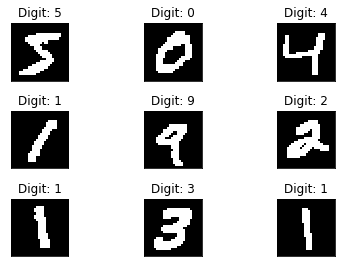

In [11]:
# Load MNIST data
(train, train_y), (test, test_y) = mnist.load_data()

# Converting to binary
train[[*np.argwhere(train>0).T]] = 1
test[[*np.argwhere(test>0).T]] = 1


fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(train[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(train_y[i]))
  plt.xticks([])
  plt.yticks([])

In [12]:
# Split data into Train, Val, Test and flatten the images
frac = 0.15

n = int(frac*(train.shape[0]))
val = train[:n]
train = train[n:]

train = train.reshape(train.shape[0], -1)
val = val.reshape(val.shape[0], -1)
test = test.reshape(test.shape[0], -1)

print('Train: ', train.shape)
print('Val: ', val.shape)
print('Test:  ', test.shape)

Train:  (51000, 784)
Val:  (9000, 784)
Test:   (10000, 784)


# Train and Inference

In [22]:
# RBM config
num_hidden = 256 # number of hidden units
lr = 0.001 # learning rate for gradient descent
n = 1 # number of Gibbs sampling steps
batch_size = 100 # mini batch size for gradient update
epochs = 100 # number of epochs

In [ ]:
rbm = RBM(num_hidden, val.shape[1], lr, n, batch_size, epochs)
train_loss, val_loss = rbm.Train(train, val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Epoch 1 ------> Error => Train : 163.1499019607843, Val : 162.3958888888889
Epoch 2 ------> Error => Train : 148.05913725490194, Val : 147.4051111111111
Epoch 3 ------> Error => Train : 134.47050980392157, Val : 133.86744444444443
Epoch 4 ------> Error => Train : 124.04627450980392, Val : 123.40644444444445
Epoch 5 ------> Error => Train : 116.4697843137255, Val : 115.65044444444445
Epoch 6 ------> Error => Train : 110.9540980392157, Val : 110.20855555555556
Epoch 7 ------> Error => Train : 106.66366666666667, Val : 105.81666666666666
Epoch 8 ------> Error => Train : 103.33003921568627, Val : 102.46777777777777
Epoch 9 ------> Error => Train : 100.44394117647059, Val : 99.74700000000001
Epoch 10 ------> Error => Train : 97.91754901960783, Val : 97.3591111111111
Epoch 11 ------> Error => Train : 95.83496078431372, Val : 95.26666666666667
Epoch 12 ------> Error => Train : 93.83923529411766, Val : 93.00200000000001
Epoch 13 ------> Error => Train : 92.2534705882353, Val : 91.6024444444444

Text(0, 0.5, 'Error')

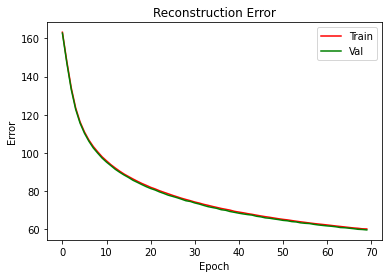

In [19]:
fig = plt.figure()
plt.plot(train_loss, c='r', label="Train")
plt.plot(val_loss, c='g', label="Val")
plt.legend()
plt.title("Reconstruction Error")
plt.xlabel("Epoch")
plt.ylabel("Error")

# Test data image reconstruction

---





Original Images ....


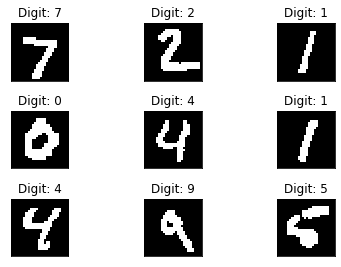

In [20]:
print("\n\nOriginal Images ....")
fig1 = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(test[i].reshape((28,28)), cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(test_y[i]))
  plt.xticks([])
  plt.yticks([])



Sampled images....


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


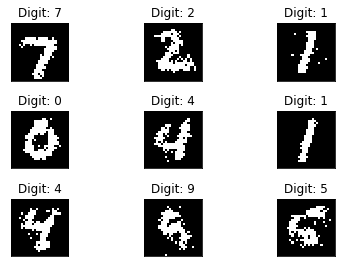

In [21]:
print("\n\nSampled images....")
fig2 = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()

  # 1 step sampling
  img = rbm.reconstruct_image(test[i].T.reshape((784,1)))

  plt.imshow(img.reshape((28,28)), cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(test_y[i]))
  plt.xticks([])
  plt.yticks([])